[[0.16472466 0.70181174 0.5610082  ... 0.84576502 0.7273671  0.91632734]
 [0.7493251  0.25035235 0.39306813 ... 0.82764877 0.59852292 0.90217231]
 [0.58682996 0.14350095 0.94380259 ... 0.27995172 0.05765418 0.99815708]
 ...
 [0.32183759 0.23396519 0.46854059 ... 0.41173306 0.27374197 0.35393041]
 [0.04186927 0.61850514 0.15185132 ... 0.34728745 0.44147767 0.70486376]
 [0.47074555 0.47173241 0.68319452 ... 0.24351044 0.41836324 0.32966638]]


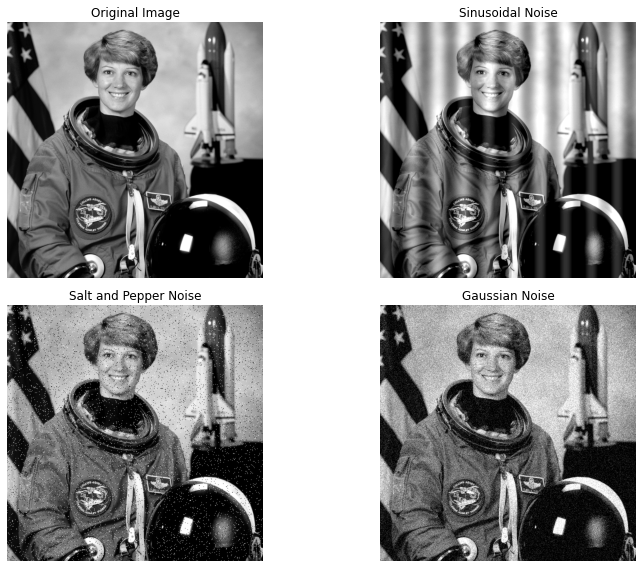

In [110]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, color
# Funzione per aggiungere rumore sinusoidale
def add_sinusoidal_noise(image, frequency=10, amplitude=50):
    rows, cols = image.shape
    x = np.arange(cols)
    sinusoidal_noise = amplitude * np.sin(2 * np.pi * frequency * x / cols)
    sinusoidal_noise = np.tile(sinusoidal_noise, (rows, 1))
    noisy_image = image + sinusoidal_noise
    return np.clip(noisy_image, 0, 255).astype(np.uint8)

# Funzione per aggiungere rumore salt-and-pepper
def add_salt_and_pepper_noise(image, prob=0.05):
    noisy_image = image.copy()
    salt_pepper = np.random.rand(*image.shape)
    print(salt_pepper)
    noisy_image[salt_pepper < prob / 2] = 0
    noisy_image[salt_pepper > 1 - prob / 2] = 255
    return noisy_image,salt_pepper

# Funzione per aggiungere rumore gaussiano
def add_gaussian_noise(image, mean=0, std=25):
    gaussian_noise = np.random.normal(mean, std, image.shape).astype(np.float32)
    noisy_image = image.astype(np.float32) + gaussian_noise
    return np.clip(noisy_image, 0, 255).astype(np.uint8)

# Caricare un'immagine in scala di grigi
#image_path = 'path_to_your_image.jpg'  # Sostituisci con il percorso dell'immagine
image = data.astronaut()[:, :, 1]

if image is None:
    raise ValueError("Immagine non trovata. Verifica il percorso fornito.")

# Aggiungere i diversi tipi di rumore
sinusoidal_noisy = add_sinusoidal_noise(image)
salt_and_pepper_noisy, _ = add_salt_and_pepper_noise(image)
gaussian_noisy = add_gaussian_noise(image)

# Visualizzare le immagini
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.title("Original Image")
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.title("Sinusoidal Noise")
plt.imshow(sinusoidal_noisy, cmap='gray')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.title("Salt and Pepper Noise")
plt.imshow(salt_and_pepper_noisy, cmap='gray')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.title("Gaussian Noise")
plt.imshow(gaussian_noisy, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()


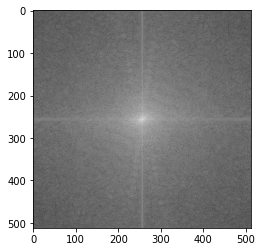

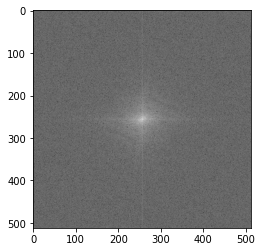

In [111]:
plt.imshow(1+np.log(np.abs(np.fft.fftshift(np.fft.fft2(image)))), cmap='gray')
plt.show()
plt.imshow(1+np.log(np.abs(np.fft.fftshift(np.fft.fft2(salt_and_pepper_noisy)))), cmap='gray')
plt.show()
#plt.imshow(1+np.log(np.abs(np.fft.fftshift(np.fft.fft2(salt_and_pepper_noisy)))), cmap='gray')
#plt.show()

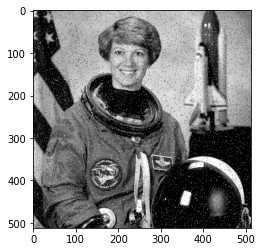

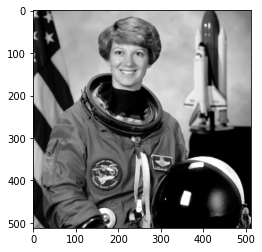

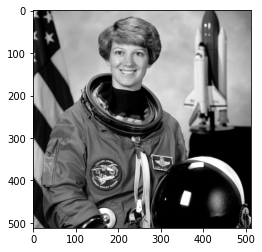

In [113]:
def remove_salt_and_pepper_noise(image):
    return cv2.medianBlur(image, 3)

salt_and_pepper_denoised = remove_salt_and_pepper_noise(salt_and_pepper_noisy)

plt.imshow(salt_and_pepper_noisy, cmap='gray')
plt.show()
plt.imshow(salt_and_pepper_denoised, cmap='gray')
plt.show()
plt.imshow(image, cmap='gray')
plt.show()

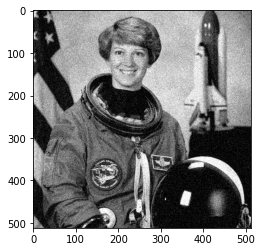

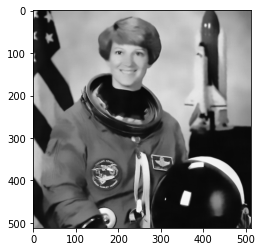

In [116]:
#Non-Local Means Denoising algorithm

#The method is based on a simple principle: 
# replacing the color of a pixel with an average of the colors of similar pixels. 
# But the most similar pixels to a given pixel have no reason to be close at all. 
# It is therefore licit to scan a vast portion of the image in search of all the pixels that really resemble the pixel one wants to denoise. 
# link paper: https://www.ipol.im/pub/art/2011/bcm_nlm/article.pdf
# link https://www.ipol.im/pub/art/2011/bcm_nlm/

def remove_gaussian_noise(image):
    return cv2.fastNlMeansDenoising(image, None, 30, 7, 21)

gaussian_denoised = remove_gaussian_noise(gaussian_noisy)

plt.imshow(gaussian_noisy, cmap='gray')
plt.show()
plt.imshow(gaussian_denoised, cmap='gray')
plt.show()



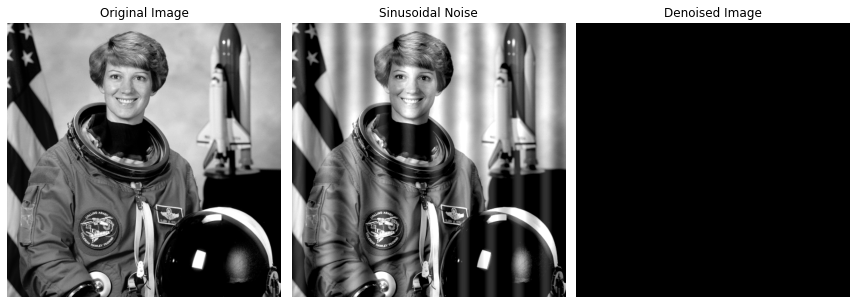

In [117]:
def remove_sinusoidal_noise(image):
    # Trasformata di Fourier dell'immagine
    dft = cv2.dft(np.float32(image), flags=cv2.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)  # Centrare lo spettro delle frequenze

    # Creazione della maschera per rimuovere frequenze specifiche
    rows, cols = image.shape
    crow, ccol = rows // 2, cols // 2  # Coordinate del centro

    # Creare una maschera circolare con un notch per rimuovere la frequenza del rumore
    mask = np.ones((rows, cols, 2), np.uint8)
    radius = 15  # Raggio del notch
    freq_offset = 20  # Offset per individuare il rumore
    mask[crow-radius:crow+radius, ccol-freq_offset-radius:ccol-freq_offset+radius] = 0
    mask[crow-radius:crow+radius, ccol+freq_offset-radius:ccol+freq_offset+radius] = 0

    # Applicare la maschera
    fshift = dft_shift * mask

    # Tornare nello spazio immagine
    f_ishift = np.fft.ifftshift(fshift)
    img_back = cv2.idft(f_ishift)
    img_back = cv2.magnitude(img_back[:, :, 0], img_back[:, :, 1])

    # Normalizzare l'immagine risultante
    return np.clip(img_back, 0, 255).astype(np.uint8)

# Rimuovere il rumore sinusoidale
sinusoidal_denoised = remove_sinusoidal_noise(sinusoidal_noisy)

# Plot delle immagini
plt.figure(figsize=(12, 8))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Sinusoidal Noise")
plt.imshow(sinusoidal_noisy, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Denoised Image")
plt.imshow(sinusoidal_denoised, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()


[[0.29024887 0.45215009 0.4197052  ... 0.9641327  0.81204359 0.84427349]
 [0.31930791 0.37465136 0.14714645 ... 0.55390642 0.43931769 0.47540587]
 [0.07041945 0.01025613 0.85977071 ... 0.99957732 0.95365997 0.42980475]
 ...
 [0.15811015 0.12712479 0.49604777 ... 0.77110216 0.88865818 0.21173501]
 [0.41771271 0.59493578 0.75845583 ... 0.9936386  0.73405383 0.60779494]
 [0.4375732  0.97248192 0.82240862 ... 0.00923803 0.98283356 0.74287148]]


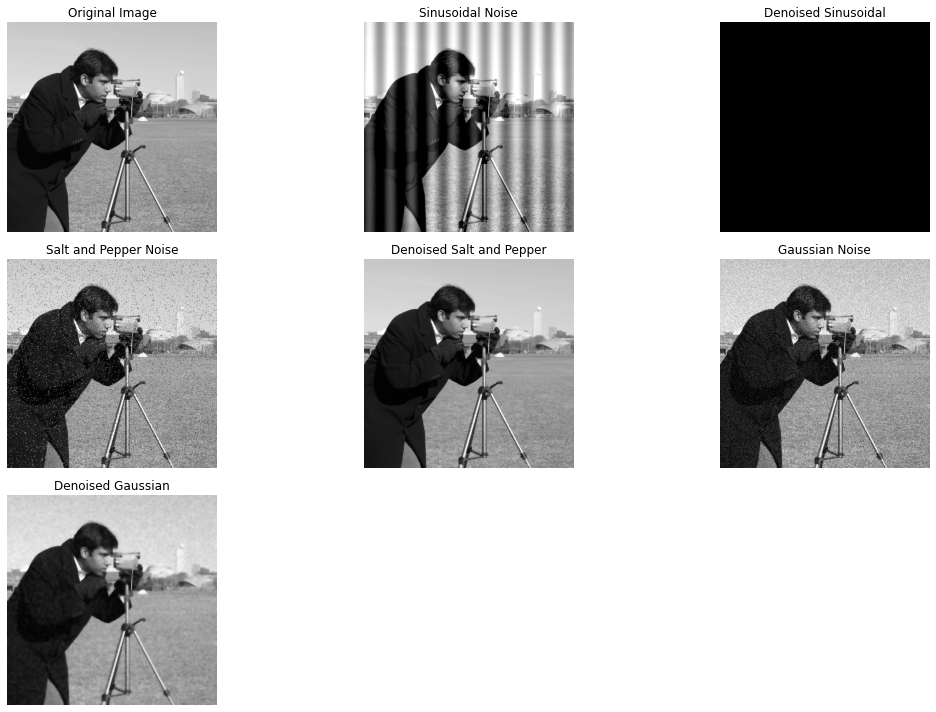

In [118]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import data

# Funzione per rimuovere il rumore sinusoidale usando la trasformata di Fourier
def remove_sinusoidal_noise(image):
    dft = cv2.dft(np.float32(image), flags=cv2.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)
    
    # Creare un filtro passa-basso
    rows, cols = image.shape
    crow, ccol = rows // 2, cols // 2
    mask = np.ones((rows, cols, 2), np.uint8)
    mask[crow-30:crow+30, ccol-30:ccol+30] = 0  # Bloccare le alte frequenze

    # Applicare il filtro
    fshift = dft_shift * mask
    f_ishift = np.fft.ifftshift(fshift)
    img_back = cv2.idft(f_ishift)
    img_back = cv2.magnitude(img_back[:, :, 0], img_back[:, :, 1])
    
    return np.clip(img_back, 0, 255).astype(np.uint8)

# Funzione per rimuovere il rumore salt-and-pepper usando il filtro mediano
def remove_salt_and_pepper_noise(image, kernel_size=3):
    return cv2.medianBlur(image, kernel_size)

# Funzione per rimuovere il rumore gaussiano usando il filtro gaussiano
def remove_gaussian_noise(image, diameter=9, sigma_color=75, sigma_space=75):
    """
    Applica un filtro bilaterale per rimuovere il rumore gaussiano preservando i bordi.
    
    Parameters:
    - diameter: Distanza dei pixel da considerare.
    - sigma_color: Filtro per differenze di colore.
    - sigma_space: Filtro per differenze spaziali.
    
    Returns:
    - Denoised image.
    """
    return cv2.bilateralFilter(image, diameter, sigma_color, sigma_space)

# Caricare un'immagine dal dataset di scikit-image
image = data.camera()

# Aggiungere rumore
sinusoidal_noisy = add_sinusoidal_noise(image)
salt_and_pepper_noisy, _ = add_salt_and_pepper_noise(image)
gaussian_noisy = add_gaussian_noise(image)

# Rimuovere il rumore
sinusoidal_denoised = remove_sinusoidal_noise(sinusoidal_noisy)
salt_and_pepper_denoised = remove_salt_and_pepper_noise(salt_and_pepper_noisy)
gaussian_denoised = remove_gaussian_noise(gaussian_noisy)

# Visualizzare i risultati
plt.figure(figsize=(15, 10))

plt.subplot(3, 3, 1)
plt.title("Original Image")
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(3, 3, 2)
plt.title("Sinusoidal Noise")
plt.imshow(sinusoidal_noisy, cmap='gray')
plt.axis('off')

plt.subplot(3, 3, 3)
plt.title("Denoised Sinusoidal")
plt.imshow(sinusoidal_denoised, cmap='gray')
plt.axis('off')

plt.subplot(3, 3, 4)
plt.title("Salt and Pepper Noise")
plt.imshow(salt_and_pepper_noisy, cmap='gray')
plt.axis('off')

plt.subplot(3, 3, 5)
plt.title("Denoised Salt and Pepper")
plt.imshow(salt_and_pepper_denoised, cmap='gray')
plt.axis('off')

plt.subplot(3, 3, 6)
plt.title("Gaussian Noise")
plt.imshow(gaussian_noisy, cmap='gray')
plt.axis('off')

plt.subplot(3, 3, 7)
plt.title("Denoised Gaussian")
plt.imshow(gaussian_denoised, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()


Enter type of noise:- 
1.Vertical Noise
2.Horizontal Noise
3.Right Diagonal Noise
4.Left Diagonal Noise



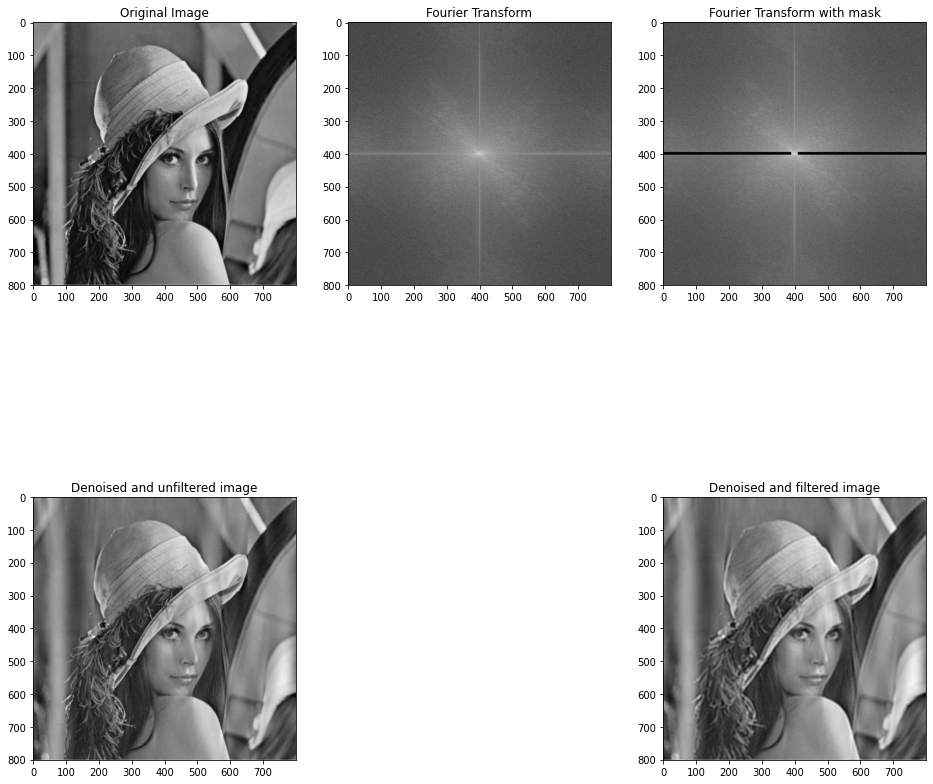

In [120]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt


def distance(point1, point2):
    return sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)


def butterworthLP(D0, imgShape, n):
    base = np.zeros(imgShape[:2])
    rows, cols = imgShape[:2]
    center = (rows / 2, cols / 2)
    for x in range(cols):
        for y in range(rows):
            base[y, x] = 1 / (1 + (distance((y, x), center) / D0) ** (2 * n))
    return base


img = cv.imread('ch3f18.jpg', cv.IMREAD_GRAYSCALE)

fourier_transform = np.fft.fft2(img)
center_shift = np.fft.fftshift(fourier_transform)

fourier_noisy = 1 + np.log(np.abs(center_shift))

rows, cols = img.shape
crow, ccol = rows // 2, cols // 2

print("Enter type of noise:- \n1.Vertical Noise\n2.Horizontal Noise\n3.Right Diagonal Noise\n4.Left Diagonal Noise\n")
val = 1

if val == 1:
    # horizontal mask
    center_shift[crow - 4:crow + 4, 0:ccol - 10] = 1
    center_shift[crow - 4:crow + 4, ccol + 10:] = 1
elif val == 2:
    # vertical mask
    center_shift[:crow - 10, ccol - 4:ccol + 4] = 1
    center_shift[crow + 10:, ccol - 4:ccol + 4] = 1
elif val == 3:
    # diagonal-1 mask
    for x in range(0, rows):
        for y in range(0, cols):
            if (x == y):
                for i in range(0, 10):
                    center_shift[x - i, y] = 1
elif val == 4:
    # diagonal-2 mask
    for x in range(0, rows):
        for y in range(0, cols):
            if (x + y == cols):
                for i in range(0, 10):
                    center_shift[x - i, y] = 1

else:
    print("Invalid Input")

filtered = center_shift * butterworthLP(80, img.shape, 10)

f_shift = np.fft.ifftshift(center_shift)
denoised_image = np.fft.ifft2(f_shift)
denoised_image = np.real(denoised_image)

f_ishift_blpf = np.fft.ifftshift(filtered)
denoised_image_blpf = np.fft.ifft2(f_ishift_blpf)
denoised_image_blpf = np.real(denoised_image_blpf)

fourier_noisy_noise_removed = 20 * np.log(np.abs(center_shift))

fig = plt.figure(figsize=(16, 16))
ax1 = fig.add_subplot(2, 3, 1)
ax1.title.set_text("Original Image")
ax1.imshow(img, cmap='gray')
ax2 = fig.add_subplot(2, 3, 2)
ax2.imshow(fourier_noisy, cmap='gray')
ax2.title.set_text("Fourier Transform")
ax3 = fig.add_subplot(2, 3, 3)
ax3.imshow(fourier_noisy_noise_removed, cmap='gray')
ax3.title.set_text("Fourier Transform with mask")
ax4 = fig.add_subplot(2, 3, 4)
ax4.imshow(denoised_image, cmap='gray')
ax4.title.set_text("Denoised and unfiltered image")
ax5 = fig.add_subplot(2, 3, 6)
ax5.imshow(denoised_image_blpf, cmap='gray')
ax5.title.set_text("Denoised and filtered image")

plt.show()


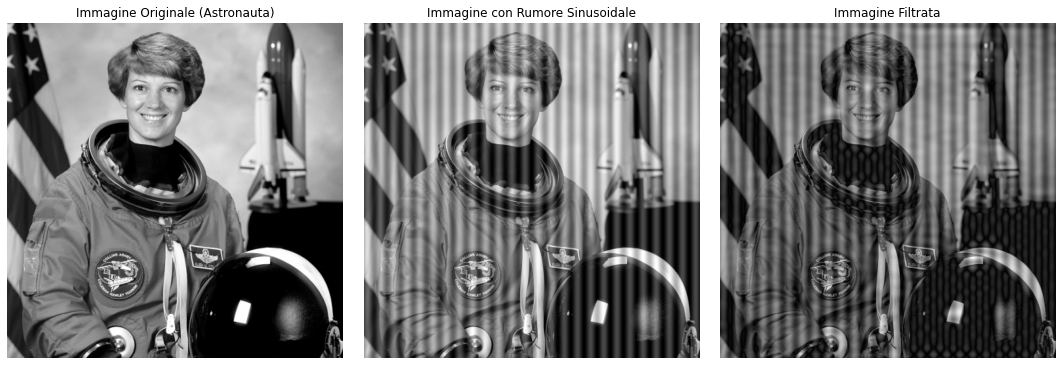

In [121]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.data import astronaut
from skimage.color import rgb2gray
from scipy.fftpack import fft2, ifft2, fftshift, ifftshift

def remove_sinusoidal_noise(image, noise_positions, radius=5):
    # Trasformata di Fourier e spostamento dello spettro
    f_transform = fft2(image)
    f_shift = fftshift(f_transform)
    
    # Creazione della maschera
    rows, cols = image.shape
    mask = np.ones((rows, cols), dtype=np.float32)
    for (x, y) in noise_positions:
        y_indices, x_indices = np.ogrid[:rows, :cols]
        distance = (x_indices - x)**2 + (y_indices - y)**2
        mask[distance <= radius**2] = 0  # Rimuovi le frequenze vicino ai picchi

    # Applica la maschera
    f_shift_filtered = f_shift * mask

    # Trasformata inversa per tornare al dominio spaziale
    f_ishift = ifftshift(f_shift_filtered)
    image_filtered = np.abs(ifft2(f_ishift))

    return image_filtered

# Carica l'immagine dell'astronauta e converti in scala di grigi
astronaut_image = rgb2gray(astronaut())
astronaut_image = astronaut_image / np.max(astronaut_image)  # Normalizza tra 0 e 1

# Aggiunta di rumore sinusoidale
rows, cols = astronaut_image.shape
x = np.arange(cols)
y = np.arange(rows)
X, Y = np.meshgrid(x, y)
sinusoidal_noise = 0.2 * np.sin(2 * np.pi * X / 20)  # Rumore sinusoidale
noisy_astronaut = astronaut_image + sinusoidal_noise

# Rimuovi il rumore sinusoidale
noise_positions = [(rows // 2, cols // 2 + 25), (rows // 2, cols // 2 - 25)]  # Frequenze del rumore
filtered_astronaut = remove_sinusoidal_noise(noisy_astronaut, noise_positions, radius=10)

# Visualizza i risultati
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title("Immagine Originale (Astronauta)")
plt.imshow(astronaut_image, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Immagine con Rumore Sinusoidale")
plt.imshow(noisy_astronaut, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Immagine Filtrata")
plt.imshow(filtered_astronaut, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()


In [102]:
_, spnoise = add_salt_and_pepper_noise(image)

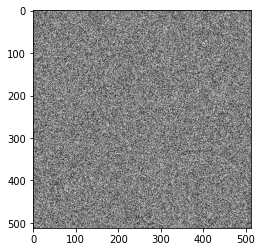

In [ ]:
plt.imshow(salt_and_pepper_noisy, cmap='gray')

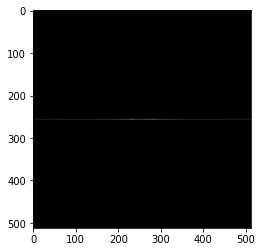

In [122]:
# Come appare il rumore sinusoidale

plt.imshow(1+np.log(1+ np.abs(np.fft.fftshift(np.fft.fft2(sinusoidal_noise)))), cmap='gray')

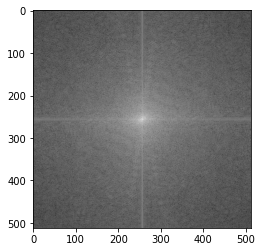

In [75]:
plt.imshow(1+np.log(np.abs(np.fft.fftshift(np.fft.fft2(astronaut_image)))), cmap='gray')

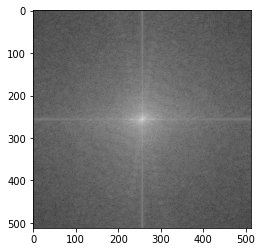

In [74]:
plt.imshow(1+np.log(np.abs(np.fft.fftshift(np.fft.fft2(noisy_astronaut)))), cmap='gray')

Enter type of noise:- 
1.Vertical Noise
2.Horizontal Noise
3.Right Diagonal Noise
4.Left Diagonal Noise



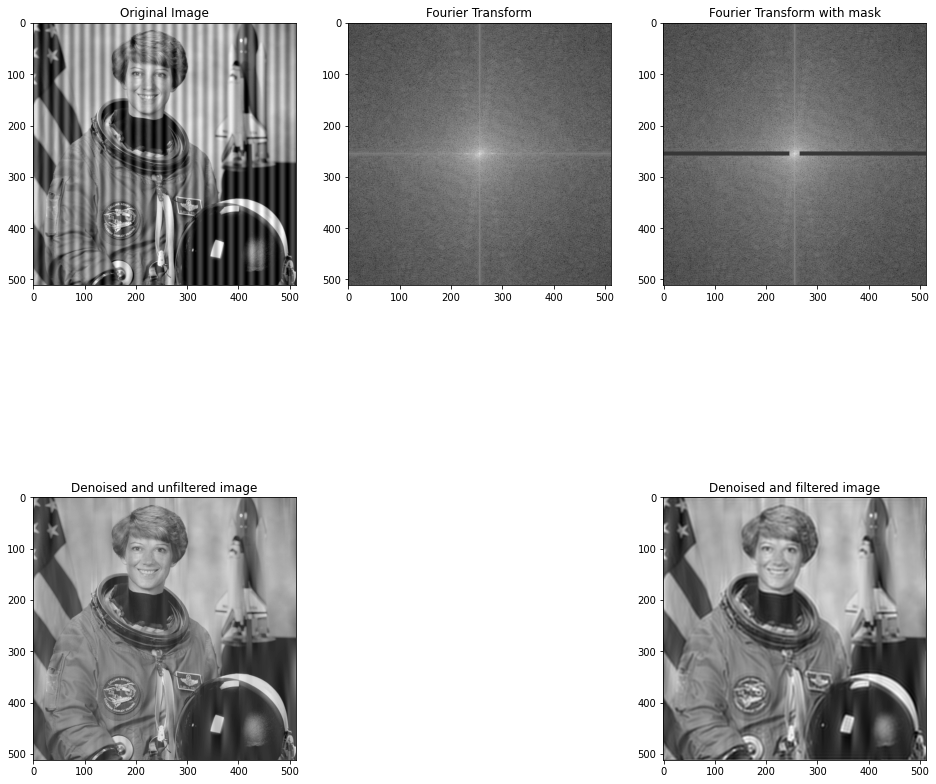

In [123]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt


def distance(point1, point2):
    return sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)


def butterworthLP(D0, imgShape, n):
    base = np.zeros(imgShape[:2])
    rows, cols = imgShape[:2]
    center = (rows / 2, cols / 2)
    for x in range(cols):
        for y in range(rows):
            base[y, x] = 1 / (1 + (distance((y, x), center) / D0) ** (2 * n))
    return base


img = noisy_astronaut

fourier_transform = np.fft.fft2(img)
center_shift = np.fft.fftshift(fourier_transform)

fourier_noisy = 1 + np.log(np.abs(center_shift))

rows, cols = img.shape
crow, ccol = rows // 2, cols // 2

print("Enter type of noise:- \n1.Vertical Noise\n2.Horizontal Noise\n3.Right Diagonal Noise\n4.Left Diagonal Noise\n")
val = 1

if val == 1:
    # horizontal mask
    center_shift[crow - 4:crow + 4, 0:ccol - 10] = 1
    center_shift[crow - 4:crow + 4, ccol + 10:] = 1
elif val == 2:
    # vertical mask
    center_shift[:crow - 10, ccol - 4:ccol + 4] = 1
    center_shift[crow + 10:, ccol - 4:ccol + 4] = 1
elif val == 3:
    # diagonal-1 mask
    for x in range(0, rows):
        for y in range(0, cols):
            if (x == y):
                for i in range(0, 10):
                    center_shift[x - i, y] = 1
elif val == 2:
    # diagonal-2 mask
    for x in range(0, rows):
        for y in range(0, cols):
            if (x + y == cols):
                for i in range(0, 10):
                    center_shift[x - i, y] = 1

else:
    print("Invalid Input")

filtered = center_shift * butterworthLP(80, img.shape, 10)

f_shift = np.fft.ifftshift(center_shift)
denoised_image = np.fft.ifft2(f_shift)
denoised_image = np.real(denoised_image)

f_ishift_blpf = np.fft.ifftshift(filtered)
denoised_image_blpf = np.fft.ifft2(f_ishift_blpf)
denoised_image_blpf = np.real(denoised_image_blpf)

fourier_noisy_noise_removed = 20 * np.log(np.abs(center_shift))

fig = plt.figure(figsize=(16, 16))
ax1 = fig.add_subplot(2, 3, 1)
ax1.title.set_text("Original Image")
ax1.imshow(img, cmap='gray')
ax2 = fig.add_subplot(2, 3, 2)
ax2.imshow(fourier_noisy, cmap='gray')
ax2.title.set_text("Fourier Transform")
ax3 = fig.add_subplot(2, 3, 3)
ax3.imshow(fourier_noisy_noise_removed, cmap='gray')
ax3.title.set_text("Fourier Transform with mask")
ax4 = fig.add_subplot(2, 3, 4)
ax4.imshow(denoised_image, cmap='gray')
ax4.title.set_text("Denoised and unfiltered image")
ax5 = fig.add_subplot(2, 3, 6)
ax5.imshow(denoised_image_blpf, cmap='gray')
ax5.title.set_text("Denoised and filtered image")

plt.show()


In [ ]:
cv2.cvtColor(data.astronaut(), cv2.)